In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
bp_network_dir = home_dir + '/trained_networks/backprop_trained/'
bp_pso_network_dir = home_dir + '/trained_networks/backprop_and_pso_trained/'
import time
import importlib
from collections import Counter
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping, TerminateOnNaN
from loading_datasets import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import multiprocessing as mp
import datetime
import codecs, json
import corner
import pickle
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport observational_data_management
%aimport multiprocessing_modules
%aimport plotting
%aimport model_setup
from data_processing import *
from observational_data_management import *
from multiprocessing_modules import train_net, init
from plotting import *
from model_setup import *

np.random.seed(999)
random.seed(999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

### Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

In [ ]:
from scipy.stats import binned_statistic
a = np.random.normal(size=(100), loc=10.5)
# print(a)
# print(training_data_dict['real_clustering_data']['stellar_mass_bin_edges'])
bin_means, bin_edges, bin_numbers = binned_statistic(a, a, bins=training_data_dict['real_clustering_data']['stellar_mass_bin_edges'], statistic='mean')
print(bin_numbers)

### Load existing models

In [93]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_train-test-val080-010-010_tanh_Halo_mass_peak-Scale_peak_mass-Halo_growth_rate-Halo_radius-Redshift_to_Stellar_mass-SFR_test_score4.37e-07'
model = load_model(bp_network_dir + model_name + '/model.h5')
training_data_dict = pickle.load(open(bp_network_dir + model_name + '/training_data_dict.p', 'rb'))
training_data_dict = make_all_data_train(training_data_dict)
training_data_dict = add_obs_data(training_data_dict, {'stellar_mass_bin_width': 0.2}, real_obs=True)
# data_keys = pickle.load(open(bp_network_dir + model_name + '/data_keys.p', 'rb'))

position = pickle.load(open(bp_network_dir + model_name + '/best_position.p', 'rb'))

max resolvable stellar masses are, for redshifts 0.00, 0.10, 0.20, 0.50, 1.00, 2.00, 3.00, 4.00, 6.00, 8.00:  [11.917698348869193, 11.919560018029657, 11.919560018029657, 12.008884738658642, 11.950992202758789, 11.871992912521591, 11.946076673215574, 11.745095703480121, 10.917188149815923, 9.582553102113343]


In [99]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_train-test-val080-010-010_tanh_Halo_mass_peak-Scale_peak_mass-Halo_growth_rate-Halo_radius-Redshift_to_Stellar_mass-SFR_test_score4.37e-07__fq-ssfr-smf-csfrd-wp_1-1-1-1-1_inertiaStart5_200Explore_new'
iteration = '1-42'

model = load_model(bp_pso_network_dir + 'real_observations/' + model_name + '/training_best/iteration_{}.h5'.format(iteration))
training_data_dict = pickle.load(open(bp_pso_network_dir + 'real_observations/' + model_name + '/full_training_data_dict.p', 'rb'))
# training_data_dict = make_all_data_train(training_data_dict)

### Get the standard plots

In [100]:
mode = 'test' # 'train', 'val, 'test'

In [101]:
norm_scores = model.evaluate(x=training_data_dict['input_{}_dict'.format(mode)], y=training_data_dict['output_{}_dict'.format(mode)],
                                               sample_weight=training_data_dict['{}_weights'.format(mode)], verbose=1)
tot_score = norm_scores[0]

249018/249018 [==============================] - 15s 62us/step


In [102]:
predicted_points = predict_points(model, training_data_dict, data_type = mode, original_units=True)
# title = 'Inputs: {}\n{:.1e} train points, {} mse {:.3e}, {} data'.format(', '.join(input_features), np.shape(training_data_dict['train_coordinates'])[0], mode, tot_score, mode)

In [ ]:
print(len(predicted_points))

##### Plots

In [ ]:
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, 'SFR', data_type=mode,
                                   predicted_points = predicted_points)

/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


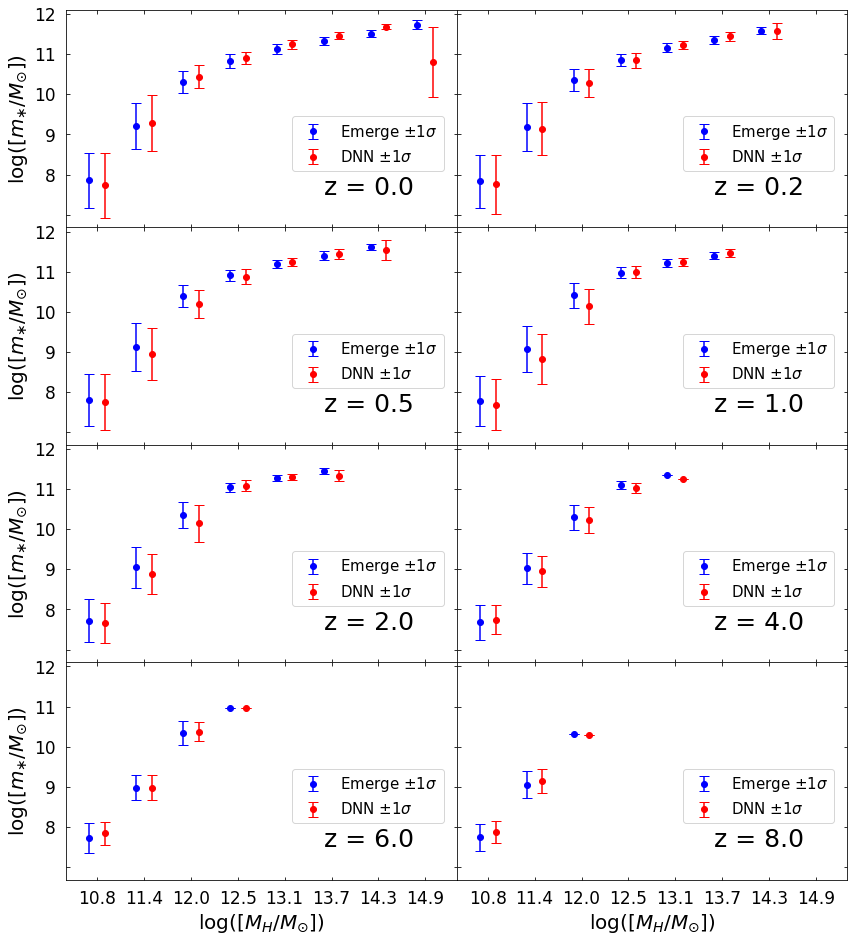

In [103]:
# Need to carry the halo masses in order to be able to plot this one. Redo the training of a 6x6 network
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', data_type=mode, redshifts=[0,.2,.5,1,2,4,6,8], n_columns=2,
                                predicted_points = predicted_points, ticksize=17)

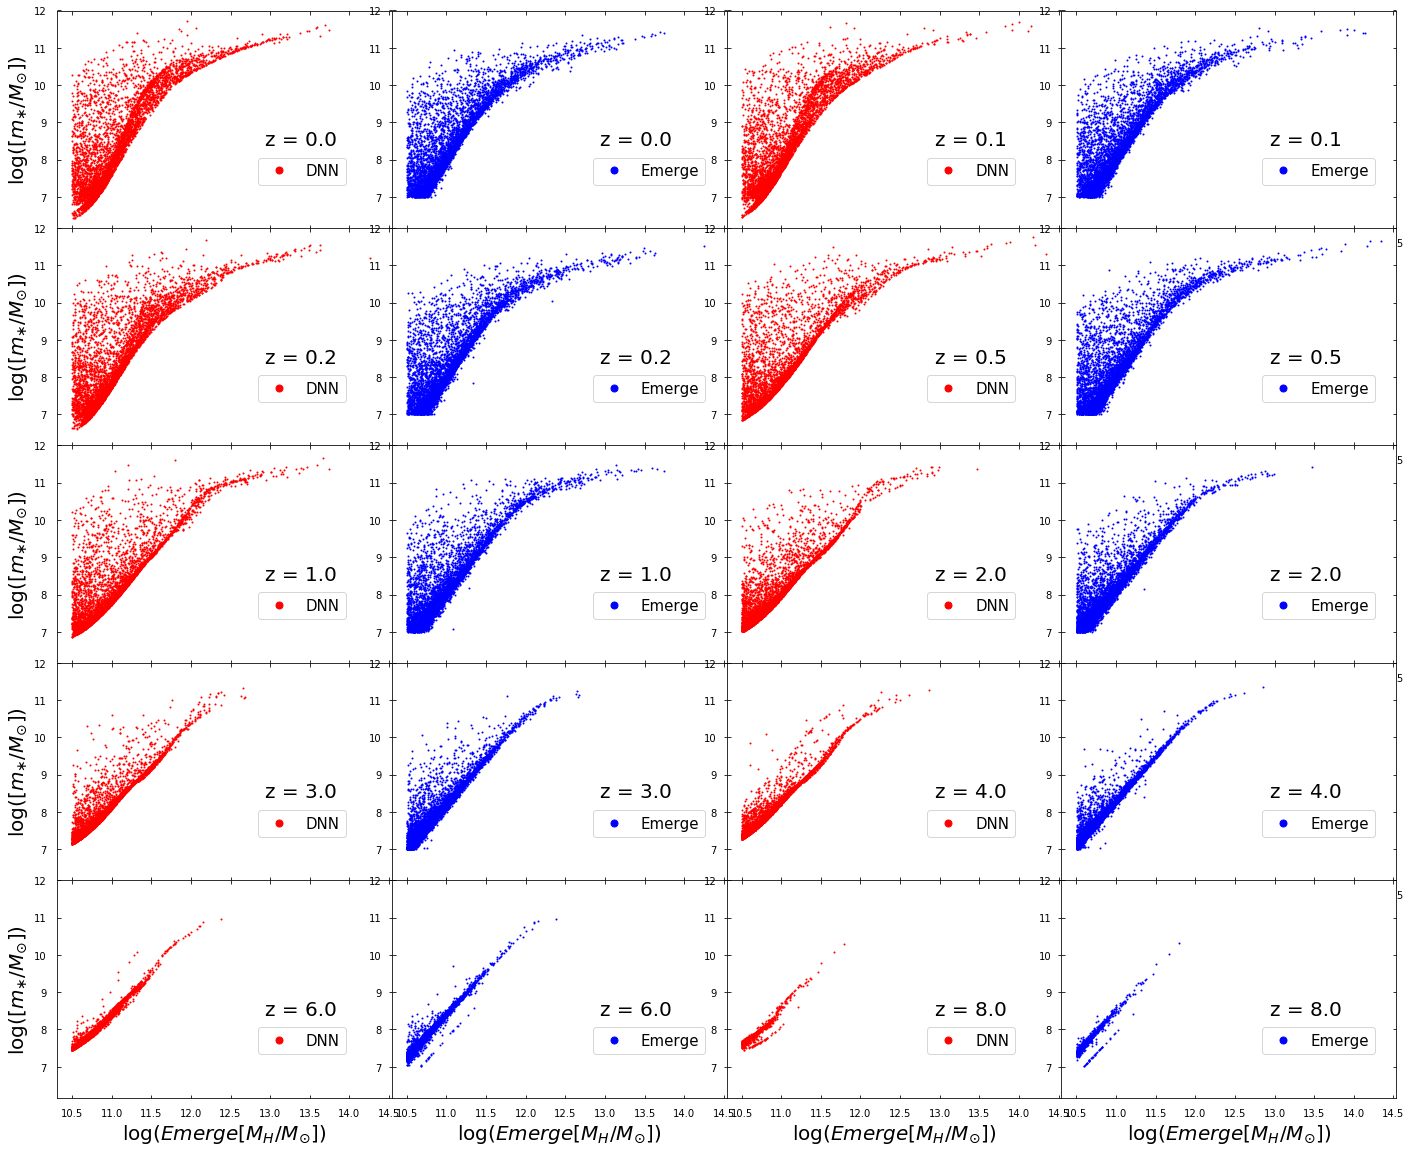

In [104]:
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, y_max = None, y_min = None, n_points=5000,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)

In [ ]:
fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, title=None, y_max = None, y_min = None, fontsize=20,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points, n_points=5000)

In [ ]:
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', data_type=mode, redshifts=[0,.2,.5,1,2,4,6,8], n_columns=2,
                                predicted_points = predicted_points)
plt.show

In [ ]:
# fig6 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Halo_mass', 
#                                  y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5, predicted_points=predicted_points,
#                                  y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2, predicted_points=predicted_points,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [ ]:
for redshift in training_data_dict['unique_redshifts']:
    fig88 = get_real_obs_plot(model, training_data_dict, redshift=redshift, title=title, data_type=mode, full_range=True)

### Load multiple models and predict observational statistics

In [93]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_train-test-val080-010-010_tanh_Halo_mass_peak-Scale_peak_mass-Halo_growth_rate-Halo_radius-Redshift_to_Stellar_mass-SFR_test_score4.37e-07'
model_1 = load_model(bp_network_dir + model_name + '/model.h5')
training_data_dict_1 = pickle.load(open(bp_network_dir + model_name + '/training_data_dict.p', 'rb'))
training_data_dict_1 = make_all_data_train(training_data_dict_1)
training_data_dict_1 = add_obs_data(training_data_dict_1, {'stellar_mass_bin_width': 0.2}, real_obs=True)
# data_keys = pickle.load(open(bp_network_dir + model_name + '/data_keys.p', 'rb'))

position = pickle.load(open(bp_network_dir + model_name + '/best_position.p', 'rb'))

max resolvable stellar masses are, for redshifts 0.00, 0.10, 0.20, 0.50, 1.00, 2.00, 3.00, 4.00, 6.00, 8.00:  [11.917698348869193, 11.919560018029657, 11.919560018029657, 12.008884738658642, 11.950992202758789, 11.871992912521591, 11.946076673215574, 11.745095703480121, 10.917188149815923, 9.582553102113343]


In [13]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_train-test-val080-010-010_tanh_Halo_mass_peak-Scale_peak_mass-Halo_growth_rate-Halo_radius-Redshift_to_Stellar_mass-SFR_test_score4.37e-07__fq-ssfr-smf-csfrd-wp_1-1-1-1-1_inertiaStart5_200Explore_new'
iteration = '1-42'

model_2 = load_model(bp_pso_network_dir + 'real_observations/' + model_name + '/training_best/iteration_{}.h5'.format(iteration))
training_data_dict_2 = pickle.load(open(bp_pso_network_dir + 'real_observations/' + model_name + '/full_training_data_dict.p', 'rb'))
training_data_dict_2 = make_all_data_train(training_data_dict_2)

In [ ]:
predicted_points_1 = predict_points(model_1, training_data_dict_1, data_type = 'train', original_units=True)
predicted_points_2 = predict_points(model_2, training_data_dict_2, data_type = 'train', original_units=True)

In [51]:
emerge_predictions = np.zeros(shape=(np.shape(predicted_points_1)))
emerge_predictions[:, 0] = training_data_dict_1['output_train_dict']['Stellar_mass']
emerge_predictions[:, 1] = training_data_dict_1['output_train_dict']['SFR']

(2490166, 2)


In [53]:
print(np.shape(emerge_predictions))
print(np.shape(predicted_points_2))
print(emerge_predictions)
print(predicted_points_2)

(2490166, 2)
(2490166, 2)
[[ 9.30191135 -0.45492649]
 [ 7.48020649 -2.82217312]
 [ 9.38104153 -0.79930305]
 ...
 [ 7.74521208 -2.40611124]
 [10.38234901 -1.6901226 ]
 [ 8.05175591 -1.76058578]]
[[ 9.273695   -0.7624153 ]
 [ 7.1940317  -2.3821812 ]
 [10.087957   -4.4036245 ]
 ...
 [ 7.3555856  -5.5335836 ]
 [10.115824    0.62275326]
 [ 7.622604   -6.335187  ]]


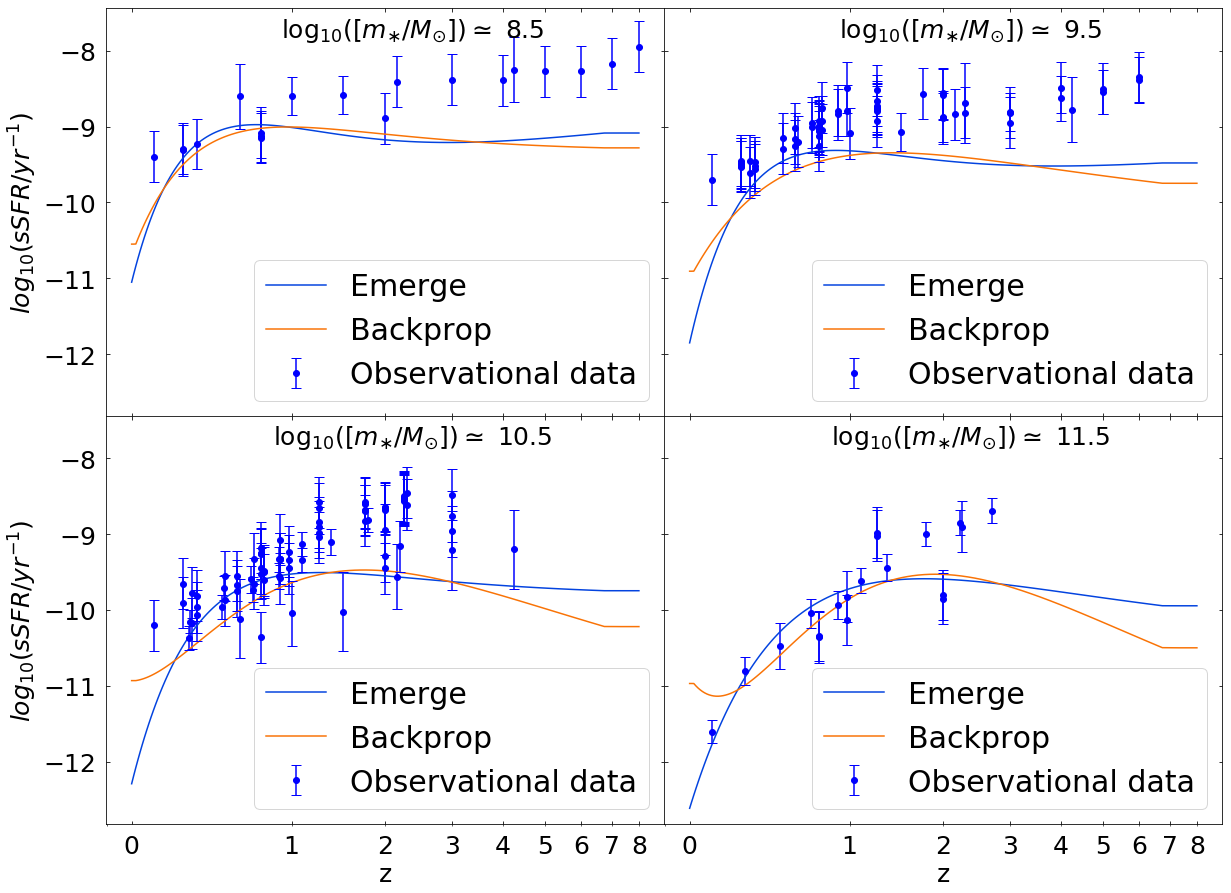

In [94]:
stellar_mass_bin_width = 0.2
fig_ssfr = ssfr_emerge_plot([emerge_predictions, predicted_points_1], training_data_dict_1, data_type='train', loss_dict={'stellar_mass_bins': np.arange(7, 12.5, stellar_mass_bin_width)},
                            model_names=['Emerge', 'Backprop'], colors=['xkcd:blue', 'xkcd:orange'])

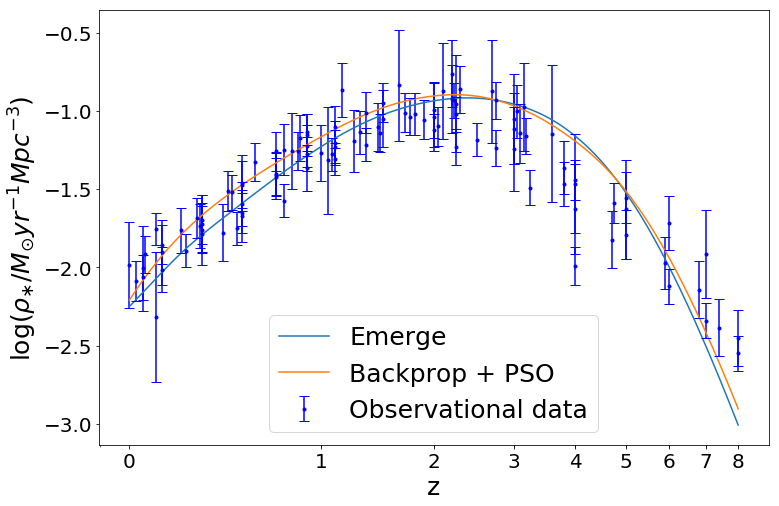

In [84]:
stellar_mass_bin_width = 0.2
fig_csfrd = get_csfrd_plot_obs([emerge_predictions, predicted_points_2], training_data_dict_2, model_names=['Emerge', 'Backprop + PSO'], colors=['xkcd:blue', 'xkcd:orange'],
                   data_type='train', loss_dict={'stellar_mass_bins': np.arange(7, 12.5, stellar_mass_bin_width)}, emerge_format=True)

### Save the figures

In [ ]:
fig1.savefig(fig_dir + model_name  +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')

In [ ]:
fig2.savefig(fig_dir + 'boxplot_stellar_mass.png', bbox_inches = 'tight')

In [ ]:
fig3.savefig(fig_dir + model_name +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')

In [ ]:
fig4.savefig(fig_dir + 'scatter_sfr_stellar_mass.png', bbox_inches = 'tight')

In [ ]:
fig5.savefig(fig_dir + 'boxplot_sfr_stellar_mass.png', bbox_inches = 'tight')

In [87]:
fig_ssfr.savefig(fig_dir + 'ssfr_obs_stats.png', bbox_inches = 'tight')

In [85]:
fig_csfrd.savefig(fig_dir + 'csfrd_obs_stats.png', bbox_inches = 'tight')

### Save model

In [ ]:
redshift_string = '-'.join(['{:02.0f}'.format(red*10) for red in redshifts])
if tot_nr_points == 'all':
    nr_points_string = 'all-points'
else:
    nr_points_string = '{:.1e}points'.format(tot_nr_points)
network_name = '{:d}x{:d}_{}_redshifts{}_train-test-val{:03.0f}-{:03.0f}-{:03.0f}_{}_{}_to_{}_{}_score{:.2e}'.format(
    network_args['nr_hidden_layers'], network_args['nr_neurons_per_lay'], nr_points_string, redshift_string, train_frac*100, val_frac*100, test_frac*100, network_args['activation_function'], 
    '-'.join(network_args['input_features']), '-'.join(network_args['output_features']), mode, tot_score
)
print(network_name)

os.makedirs(os.path.dirname(bp_network_dir + network_name + '/model.h5'), exist_ok=True)

model.save(bp_network_dir + network_name + '/model.h5')
pickle.dump(training_data_dict, open(bp_network_dir + network_name + '/training_data_dict.p', 'wb'))
# save the position in weight space for the pso algorithm to use as starting point
model_weights = model.get_weights()
position = []
for weight_matrix in model_weights:
    position.extend(np.ndarray.flatten(weight_matrix))
position = np.array(position)

pickle.dump(position, open(bp_network_dir + network_name + '/best_position.p', 'wb'))

### Set model parameters

In [ ]:
### General parameters
nr_repetitions = 1
tot_nr_points = 'all' # how many examples will be used for training+validation+testing, 'all' or a number
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1
batch_size = 4e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass_peak', 'Scale_peak_mass', 'Halo_growth_rate', 'Halo_radius', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = 5e4

early_stop_patience = 50
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
network_args = {        
    'nr_hidden_layers': 5,
    'nr_neurons_per_lay': 5,
    'input_features': input_features,
    'output_features': output_features,
    'activation_function': 'tanh', # 'tanh', 'leaky_relu'
    'output_activation': {'SFR': None, 'Stellar_mass': None},
    'reg_strength': 1e-20
}

## Load data

In [ ]:
# load the selected galaxyfile
galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, network_args, redshifts, outputs_to_weigh=outputs_to_weigh, 
                                       weigh_by_redshift=weigh_by_redshift, total_set_size=tot_nr_points, 
                                       train_frac=train_frac, val_frac=val_frac, 
                                       test_frac=test_frac, emerge_targets=True)
# galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [ ]:
model = standard_network(network_args['input_features'], network_args['output_features'], network_args['nr_neurons_per_lay'], 
                         network_args['nr_hidden_layers'], network_args['activation_function'], 
                         network_args['output_activation'], network_args['reg_strength'], clipvalue=.001)

## Train model

In [ ]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]


for i_rep in range(1, nr_repetitions+1):
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], training_data_dict['val_weights']), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=training_data_dict['train_weights'], verbose=1)

#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Input parameter search

#### Do a batch run to see which input parameters gives the best score

In [ ]:
### General parameters
nr_steps = 5e4
batch_size = .5e4
total_set_size = 3e4 # how many examples will be used for training+validation+testing
train_size = 2.5e4
val_size = .25e4
test_size = .25e4
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = True

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 20
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

### Network parameters
nr_layers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 10
reg_strength = 0#1e-5

# Batch run parameters
core_input_features = ['Halo_mass', 'Redshift']
tested_input_features = ['Scale_half_mass', 'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [1, 2, 3, 4]
nr_runs_per_comb = 3


verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activation_function,
    'neurons_per_layer': [neurons_per_layer],
    'nr_hidden_layers': [nr_layers],
    'output_activation_function': output_activation,
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs (sum of test losses).'+\
    ' The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss].'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            

            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts,
                                                   int(total_set_size), int(train_size), int(val_size), int(test_size))
            training_data_dict = normalise_data(training_data_dict, norm)
            
            earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, 
                                      patience=early_stop_patience, verbose=1, mode='auto')
            callbacks_list = [earlystop]

            train_weights, val_weights, test_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                                     weigh_by_redshift=weigh_by_redshift)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, 
                                         activation_function, output_activation, reg_strength)

                # Fit the model

                history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                                    validation_data = (training_data_dict['input_val_dict'], 
                                    training_data_dict['output_val_dict'], val_weights), 
                                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                                    sample_weight=train_weights, verbose=verb)
                score = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'], 
                                       sample_weight=test_weights, verbose=verb)
                scores.append(score[0]) # take only the sum of the output losses (total loss)
                    

                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '3-6_total_inputs_redshift_growth'
tot_string = date_string + '-' + custom_string

with open('model_comparisons/' + tot_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '2018-06-20--09-52-20-3-6_total_inputs_redshift'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

#### Plot the results

In [ ]:
print(len(results_list[1][0]))
print(results_list[1][0])
results_list[0]['nr_extra_parameter_combinations']

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_losses = lst[1]
    avg_test_loss = np.mean(test_losses)
    title = ', '.join(lst[0]) + '\naverage test loss: {:.3e}'.format(avg_test_loss)

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_losses)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][1])

In [ ]:
### Get the X best performing input parameters
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.1]
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    best_test = np.amin(lst[1])
    test_results.append(best_test)
    
best_test_indices = np.argsort(test_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

nr_fixed_inputs = len(results_list[0]['fixed_input_features'])
collabel=('Input parameters', 'best test mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:nr_fixed_inputs])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([inputs, '{:.2e} (mean: {:.2e})'.format(test_results[best_test_indices[i]], 
                                                              np.mean(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
nr_columns = 10
collabel = ['Input parameter']
[collabel.append('{:d}'.format(i)) for i in range(1, nr_columns+1)]
collabel = tuple(collabel)
#collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(nr_columns):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:nr_columns]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on best out of 3 test scores' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.9])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '3-6_total_inputs_redshift_growth' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search multiprocessing

In [ ]:
### Multiprocessing version
nr_steps = 1e5

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

nr_folds = 3
tot_nr_points = 2e5 # how many examples will be used for training+validation+testing, 'all' or a number
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

input_features = ['Halo_mass_peak', 'Scale_peak_mass', 'Halo_growth_rate', 'Halo_radius', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False
weigh_by_redshift = True

norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

nr_layers = [6, 7, 8, 9, 10, 12, 14, 16, 20]
neurons_per_layer = [6, 7, 8, 9, 10, 12, 14, 16, 20]
activation_functions = ['tanh']

loss_function = 'mse'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = np.array([1e-20]) # np.power(10, np.random.uniform(low=-20, high=-10, size=5)) 

batch_sizes = np.array([4e4]) # np.power(10, np.random.uniform(low=4, high=5, size=5))
nr_epochs = nr_steps * batch_sizes / (tot_nr_points*train_frac)
early_stop_patience = nr_epochs / 10
early_stop_min_delta = 1e-20

progress_file = 'hyperparameter_searches/progress.txt'
n_processes = 27

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'batch_sizes': batch_sizes.tolist(),
    'nr_epochs': nr_epochs.tolist(),
    'tot_nr_points': [tot_nr_points],
    'reg_strengths': reg_strengths.tolist(),
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing five objects: [parameters, test_score, train_history, '+\
    'val_history, param_id]. The first one is ' + \
    'the parameters of the model. The second one is the test score of the final model'+\
    ' ' +\
    'The third one is the training' +\
    'loss history and the fourth one is the validation loss history. '+\
    'The fifth one is an id for the parameter combinations. If there are several runs for the same combs then they will have the same id.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds


    
with open(progress_file, 'w') as f:

    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on hyperparameters on ' + date_string_proper + '\n\n' + '0/{}'.format(tot_nr_runs))
    f.flush()

# load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)

param_combos = []
param_id = 0      # for identifying the same combinations of parameters

for i_act_fun, act_fun in enumerate(activation_functions):
    for i_reg_strength, reg_strength in enumerate(reg_strengths):
        for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
#                 for i_nr_lay, nr_lay in enumerate(nr_layers):
            for i_batch_size, batch_size in enumerate(batch_sizes):

                param_id += 1
                for fold in range(nr_folds):

                    
                    ### Network parameters
                    network_args = {
                        'nr_hidden_layers': nr_layers[i_neur_per_lay],
                        'nr_neurons_per_lay': neur_per_lay,
                        'input_features': input_features,
                        'output_features': output_features,
                        'activation_function': act_fun,
                        'output_activation': output_activation,
                        'reg_strength': reg_strength
                    }

                    params = [galaxies, network_args, data_keys, redshifts, tot_nr_points, train_frac, val_frac, test_frac, outputs_to_weigh, weigh_by_redshift, 
                              norm, nr_epochs[i_batch_size], 
                              batch_size, progress_file, verb, early_stop_min_delta, 
                              early_stop_patience[i_batch_size], param_id]

                    param_combos.append(params)

write_lock = mp.Lock()
with mp.Pool(processes=n_processes, initializer=init, initargs=(write_lock,)) as pool:
    results = pool.map(train_net, param_combos)

results_list.extend(results)

with open(progress_file, 'a') as f:
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('\nBenchmark completed at ' + date_string_proper + '\n')
    f.flush()

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = 'network_size'
tot_string = date_string + '_' + custom_string + '.json'
with open('hyperparameter_searches/' + tot_string, 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:
### Load a result
loaded_list_string = '2018-09-21--11-21-31_broad_sweep'
with open('hyperparameter_searches/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

In [ ]:
print(results_list[0])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
contains_data_list = [True if lst[1] else False for lst in results_list[1:]]
print('Number of parameter combinations that ended up exploding before test loss could be evaluated: {:d}'.format(
      np.sum(not contains_data_list)))
print('Number of parameter combinations that contains at least one test loss data point: {:d}'.format(
      np.sum(contains_data_list)))
for comb_nr, lst in enumerate(results_list[1:]):
    
    if lst[1]:
        title = str(lst[0]) + '\n final test score: {:.2e}'.format(lst[1])
        train_losses = lst[2]
        val_losses = lst[3]

        #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

        # summarize history for loss
        fig = plt.figure(5, figsize=(12,12))
        plt.plot(range(1, len(train_losses)+1), train_losses, 'b')
        plt.plot(range(1, len(val_losses)+1), val_losses, 'r')
        plt.yscale('log')
        plt.title(title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
  #  else:
  #      print('No data here, boss')


In [ ]:
{'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
nr_lay_nans = []
neur_per_lay_nans = []
batch_size_nans = []
reg_strength_nans = []
inp_norm_nans = []
actfun_nans = []

for i_lst, lst in enumerate(results_list[1:]):

   # print(lst[2][0])
  #  print(len(lst[2][0]))
    if len(lst[2][0])%10 > 0:
        
        nr_lay_nans.append(lst[0]['nr_lay'])
        neur_per_lay_nans.append(lst[0]['neur_per_lay'])
        batch_size_nans.append(lst[0]['batch_size'])
        reg_strength_nans.append(lst[0]['reg_strength'])
        inp_norm_nans.append(lst[0]['inp_norm'])
        actfun_nans.append(lst[0]['act_fun'])
        
    #    print('object nr {}'.format(i_lst+1))
    
print('The occurrences of NaN value in the losses by input parameter')
print('nr_lays: ', dict(Counter(nr_lay_nans)))
print('neur_per_lay: ', dict(Counter(neur_per_lay_nans)))
print('batch_size: ', dict(Counter(batch_size_nans)))
print('reg_strength: ', dict(Counter(reg_strength_nans)))
print('inp_norm: ', dict(Counter(inp_norm_nans)))
print('act_fun: ', dict(Counter(actfun_nans)))

In [ ]:
['results_list[key] results_list[1][0]

In [ ]:
top_nr_of_parameter_combs = 50
column_widths = [.05] * 7
test_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    test_result = lst[1]
    test_results.append(test_result)
sort_indices = np.argsort(test_results)

fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)

collabel=('nr', 'nr_lay', 'nr_neur', 'act_fun', 'batch_size', 'reg_strength', 'test mse')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
#     'nr_lay': network_args['nr_hidden_layers'], 
#                   'neur_per_lay': network_args['nr_neurons_per_lay'], 
#                   'act_fun': network_args['activation_function'], 'batch_size': batch_size, 
#                   'reg_strength': network_args['reg_strength']
    
#     parameters = ', '.join(results_list[sort_indices[i]+1][0][:nr_fixed_inputs])
#     inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][nr_fixed_inputs:])
    
    table_vals.append([i+1, results_list[sort_indices[i]+1][0]['nr_lay'], results_list[sort_indices[i]+1][0]['neur_per_lay'], results_list[sort_indices[i]+1][0]['act_fun'], 
                       '{:.2e}'.format(results_list[sort_indices[i]+1][0]['batch_size']), '{:.2e}'.format(results_list[sort_indices[i]+1][0]['reg_strength']), 
                       '{:.2e}'.format(results_list[sort_indices[i]+1][1])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('nr_layers: ' + ', '.join([str(temp) for temp in results_list[0]['nr_hidden_layers']])
          + '\nnr_neur_per_lay: ' + ', '.join([str(temp) for temp in results_list[0]['neurons_per_layer']])
          + '\nact_funs: ' + ', '.join(results_list[0]['activation_functions'])
          + '\nbatch_sizes: ' + ', '.join(['{:.2e}'.format(temp) for temp in sorted(results_list[0]['batch_sizes'])])
          + '\nreg_strengts: ' + ', '.join(['{:.2e}'.format(temp) for temp in sorted(results_list[0]['reg_strengths'])]),
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 3.4])

plt.show()

In [ ]:
fig.savefig('hyperparameter_searches/' + loaded_list_string + '_top{:d}.png'.format(top_nr_of_parameter_combs), bbox_inches = 'tight')

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Hyperparameter search, GPUs

In [ ]:
### single process, GPU version
keep_writing_to_old_file = True
file_name = '2018-09-24_network_size' # file to keep working on if keep_writing_to_old_file=True

nr_steps = 1e5 # 1e5 in full run

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

nr_folds = 3
tot_nr_points = 'all' # how many examples will be used for training+validation+testing, 'all' or a number
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

input_features = ['Halo_mass_peak', 'Scale_peak_mass', 'Halo_growth_rate', 'Halo_radius', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']
redshifts = [0,.1,.2,.5,1,2,3,4,6,8]
same_n_points_per_redshift = False
weigh_by_redshift = True

norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'

nr_layers = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20]
neurons_per_layer = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20]
activation_functions = ['tanh']

loss_function = 'mse'
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = np.array([1e-20]) # np.power(10, np.random.uniform(low=-20, high=-10, size=5)) 

batch_sizes = np.array([4e4]) # np.power(10, np.random.uniform(low=4, high=5, size=5))
if isinstance(tot_nr_points, float):
    nr_epochs = nr_steps * batch_sizes / (tot_nr_points*train_frac)
else:
    nr_epochs = nr_steps * batch_sizes / (1.29e6*train_frac)
early_stop_patience = [30]
early_stop_min_delta = 1e-20

progress_file = 'hyperparameter_searches/progress.txt'

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'batch_sizes': batch_sizes.tolist(),
    'nr_epochs': nr_epochs.tolist(),
    'tot_nr_points': [tot_nr_points],
    'reg_strengths': reg_strengths.tolist(),
    'nr_folds': nr_folds,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing five objects: [parameters, test_score, train_history, '+\
    'val_history, param_id]. The first one is ' + \
    'the parameters of the model. The second one is the test score of the final model'+\
    ' ' +\
    'The third one is the training' +\
    'loss history and the fourth one is the validation loss history. '+\
    'The fifth one is an id for the parameter combinations. If there are several runs for the same combs then they will have the same id.'
}
tot_nr_runs = len(nr_layers) * len(activation_functions) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds

run_counter = 0 # to keep track of how many combinations I've gone through

if keep_writing_to_old_file:
    ### Load a result
    if os.path.isfile('hyperparameter_searches/' + file_name + '.json'):
        with open('hyperparameter_searches/' + file_name + '.json', 'r') as ff:
            old_results_list = json.load(ff)
        ff.close()
        results_list = old_results_list.copy()
    else:
        old_results_list = []
        results_list = [parameter_dictionary]
else:
    results_list = [parameter_dictionary]

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys = load_galfiles(redshifts=redshifts, equal_numbers=same_n_points_per_redshift)

    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            f.write(date_string_proper + '  Starting new constant unit\n\n')
            f.flush()
            for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
#                 for i_nr_lay, nr_lay in enumerate(nr_layers):
                for i_batch_size, batch_size in enumerate(batch_sizes):

                    ### Network parameters
                    network_args = {        
                        'nr_hidden_layers': nr_layers[i_neur_per_lay],
                        'nr_neurons_per_lay': neur_per_lay,
                        'input_features': input_features,
                        'output_features': output_features,
                        'activation_function': act_fun,
                        'output_activation': output_activation,
                        'reg_strength': reg_strength
                    }

                    earlystop = EarlyStopping(monitor='val_loss', min_delta=early_stop_min_delta, 
                                              patience=early_stop_patience[i_batch_size], verbose=1, mode='auto')
                    nan_termination = TerminateOnNaN()
                    callbacks_list = [earlystop, nan_termination]

                    train_histories = []
                    val_histories = []
                    scores = []
                    
                    if keep_writing_to_old_file:
                        comb_tried = False
                        for params in [item[0] for item in old_results_list[1:]]:
                            if params['nr_lay'] == network_args['nr_hidden_layers']:
                                comb_tried = True
                                run_counter += nr_folds
                                
                    if (not comb_tried) or (not keep_writing_to_old_file):
                                
                        for fold in range(nr_folds):

                            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                            run_counter += 1
                            f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                            f.flush()

                            ### Prepare the training data

                            # prepare the training data
                            training_data_dict = divide_train_data(galaxies, data_keys, network_args, redshifts, 
                                                                   outputs_to_weigh=outputs_to_weigh, 
                                                                   weigh_by_redshift=weigh_by_redshift, total_set_size=tot_nr_points, 
                                                                   train_frac=train_frac, val_frac=val_frac, 
                                                                   test_frac=test_frac, emerge_targets=True)
                            # galaxies = None
                            training_data_dict = normalise_data(training_data_dict, norm)

                            model = standard_network(network_args['input_features'], network_args['output_features'], 
                                                     network_args['nr_neurons_per_lay'], network_args['nr_hidden_layers'], 
                                                     network_args['activation_function'], 
                                                     network_args['output_activation'], network_args['reg_strength'], clipvalue=.001)

                            # Fit the model                        
                            history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                                                validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                                                training_data_dict['output_'+validation_data+'_dict'], training_data_dict['val_weights']), 
                                                epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), callbacks=callbacks_list,
                                                sample_weight=training_data_dict['train_weights'], verbose=verb)

                            test_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                                         sample_weight=training_data_dict['test_weights'], verbose=verb)
                            scores.append(test_scores[0]) # take total test result

                            if 'loss' in history.history:
                                train_histories.append(history.history['loss'])
                            if 'val_loss' in history.history:                        
                                val_histories.append(history.history['val_loss'])

                        best_score = np.amin(scores)
                        mean_score = np.mean(scores)
                        score_std = np.std(scores)
                        total_score = [mean_score, score_std, best_score]
                        parameters = {'nr_lay': nr_layers[i_neur_per_lay], 'neur_per_lay': neur_per_lay, 
                                     'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                        results_list.append([parameters, total_score, train_histories, val_histories])
                        
                        with open('hyperparameter_searches/' + file_name + '.json', 'w+') as ff:
                            json.dump(results_list, ff)
                        ff.close()
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = 'network_size'
tot_string = date_string + '_' + custom_string + '.json'
with open('hyperparameter_searches/' + tot_string, 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:
### Load a result
loaded_list_string = '2018-09-24_network_size'
with open('hyperparameter_searches/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

In [ ]:
print(results_list[1][1])
print(results_list[2][1])
print(results_list[3][1])
print(results_list[4][0])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
contains_data_list = [True if lst[2] else False for lst in results_list[1:]]
print('Number of parameter combinations that ended up exploding before test loss could be evaluated: {:d}'.format(
      np.sum(not contains_data_list)))
print('Number of parameter combinations that contains at least one test loss data point: {:d}'.format(
      np.sum(contains_data_list)))
for comb_nr, lst in enumerate(results_list[1:]):
    
    if lst[2]:
        title = str(lst[0]) + '\n mean final test score: {:.2e}'.format(lst[1][0])
        fig = plt.figure(5, figsize=(12,12))
        for i in range(len(lst[2])):
            train_losses = lst[2][i]
            val_losses = lst[3][i]
            plt.plot(range(1, len(train_losses)+1), train_losses, 'b')
            plt.plot(range(1, len(val_losses)+1), val_losses, 'r')
        plt.yscale('log')
        plt.title(title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
  #  else:
  #      print('No data here, boss')


### Plot over network size importance

In [ ]:
unit_dict = get_unit_dict()
'$log_{{10}}([{}])$'.format(unit_dict['SSFR'])

In [ ]:
masses_lin_vals = np.linspace(0, 10, num=100)
scale_factors_lin_vals = np.linspace(20, 25, num=100)
masses_grid_vals, scale_factors_grid_vals = np.meshgrid(masses_lin_vals, scale_factors_lin_vals)
print(masses_lin_vals)
print(masses_grid_vals)
print(scale_factors_grid_vals)

In [ ]:
loss_color = 'xkcd:blue'
size_color = 'xkcd:orange'

fig99999 = plt.figure(figsize=(12,6))
ax1 = plt.subplot(111)
net_sizes = [lst[0]['nr_lay'] for lst in results_list[1:]]
order_indeces = np.argsort(net_sizes)
mean_test_scores = [lst[1][0] for lst in results_list[1:]]
stds = [lst[1][1] for lst in results_list[1:]]
ax1.errorbar(np.array(net_sizes)[order_indeces], np.array(mean_test_scores)[order_indeces], yerr=np.array(stds)[order_indeces], fmt='o-', markersize=3, capsize=5, color=loss_color)
ax1.set_xlabel('Network size', fontsize=25)
ax1.set_ylabel('Mean mse loss $\pm 1\sigma$', fontsize=25, color=loss_color)
ax1.set_xticks(np.array(net_sizes)[order_indeces])
ax1.tick_params(labelsize=20)
ax1.tick_params(axis='y', colors=loss_color)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax1.yaxis.get_offset_text().set_fontsize(25)
ax1.set_xlim(left=1.5)

nr_variables = []
for net_size in np.array(net_sizes)[order_indeces]:
    nr_var, weight_shapes = standard_network_get_nr_variables_weight_shapes(['tmp']*5, ['tmp']*2, net_size, net_size)
    nr_variables.append(nr_var)
ax2 = ax1.twinx()

ax2.plot(np.array(net_sizes)[order_indeces], nr_variables, 'o', color=size_color)
ax2.set_ylabel('Nr network variables', fontsize=25, color=size_color)
ax2.tick_params(axis='y', labelsize=20, colors=size_color)
ax2.semilogy()
for i, (x,y) in enumerate(zip(np.array(net_sizes)[order_indeces], nr_variables)):
    if i == 0:
        ax2.annotate('{:>4}'.format(str(y)),xy=(x-1,y*.9), fontsize=15, color=size_color)
    elif i <= 5:
        ax2.annotate('{:>4}'.format(str(y)),xy=(x-1.1,y*.9), fontsize=15, color=size_color)
    elif i <= 8:
        ax2.annotate('{:>4}'.format(str(y)),xy=(x-1.2,y*.9), fontsize=15, color=size_color)

plt.show()

In [ ]:
fig99999.savefig('hyperparameter_searches/' + loaded_list_string + '_error_plot.png', bbox_inches = 'tight')

### Old code again

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)

In [ ]:
model_name = '6x6_all-points_redshifts00-01-02-05-10-20-30-40-60-80_tanh_Halo_mass-Halo_mass_peak-Scale_peak_mass-Scale_half_mass-Halo_growth_rate-Redshift_to_Stellar_mass-SFR_test_score7.40e-07'
model = load_model(bp_network_dir + model_name + '/model.h5')
model_weights = model.get_weights()

position = []
for weight_matrix in model_weights:
    position.append(np.ndarray.flatten(weight_matrix))

pickle.dump(position, open(bp_network_dir + model_name + '/best_position.p', 'wb'))

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

In [ ]:
figggg = plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(np.arange(0,10)+1, np.sin(np.arange(0,10)+1))
ax.set_xscale('log')
ax.set_xticks(np.arange(0,10)+1)
ax.set_xticklabels(np.arange(0,10))
plt.show()